In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pyeit.eit.bp as bp
import pyeit.eit.greit as greit
import pyeit.eit.jac as jac
import pyeit.eit.protocol as protocol
import pyeit.mesh as mesh
import tensorflow as tf
from pyeit.eit.interp2d import sim2pts
from sciopy import norm_data
from sklearn.model_selection import train_test_split
from support import GREIT_sample, show_mesh
from tensorflow import GradientTape, exp, keras, reduce_mean, reduce_sum, shape, square
from tensorflow.keras import layers, models
from tensorflow.keras.layers import (
    LSTM,
    Activation,
    Add,
    BatchNormalization,
    Bidirectional,
    Concatenate,
    Conv1D,
    Conv2D,
    ConvLSTM1D,
    Cropping1D,
    Cropping2D,
    Dense,
    Dropout,
    Flatten,
    Input,
    Lambda,
    MaxPooling1D,
    Normalization,
    Reshape,
    ZeroPadding1D,
)
from tensorflow.keras.losses import Huber, binary_crossentropy, mse
from tensorflow.keras.metrics import Mean
from tensorflow.keras.models import Model

2023-10-23 14:12:37.406688: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
n_el = 16
r_obj = 0.3
h0 = 0.025
dist_exc = 8
step_meas = 4

load_path_30 = f"../data/{h0=}_{n_el=}_{r_obj=}_{dist_exc=}_{step_meas=}/"

if os.path.isdir(load_path_30):
    print("This directory exists...continue")
else:
    print("You have to generate the data...")

This directory exists...continue


In [3]:
n_el = 16
r_obj = 0.35
h0 = 0.025
dist_exc = 8
step_meas = 4

load_path_35 = f"../data/{h0=}_{n_el=}_{r_obj=}_{dist_exc=}_{step_meas=}/"

if os.path.isdir(load_path_35):
    print("This directory exists...continue")
else:
    print("You have to generate the data...")

This directory exists...continue


In [4]:
n_el = 16
r_obj = 0.4
h0 = 0.025
dist_exc = 8
step_meas = 4

load_path_40 = f"../data/{h0=}_{n_el=}_{r_obj=}_{dist_exc=}_{step_meas=}/"

if os.path.isdir(load_path_40):
    print("This directory exists...continue")
else:
    print("You have to generate the data...")

This directory exists...continue


In [5]:
V_30 = np.load(
    "../saves/" + load_path_30.split("/")[2] + "_v_data.npy", allow_pickle=True
)
V_35 = np.load(
    "../saves/" + load_path_35.split("/")[2] + "_v_data.npy", allow_pickle=True
)

V_40 = np.load(
    "../saves/" + load_path_40.split("/")[2] + "_v_data.npy", allow_pickle=True
)

In [6]:
print(V_30.shape)
print(V_35.shape)
print(V_40.shape)

(999, 192)
(999, 192)
(999, 192)


In [7]:
V_30.shape

(999, 192)

In [8]:
# creates overlapping segments with a length of nseg
nseg = 4
norm = True

if norm:
    V_30 = np.array([norm_data(v) for v in V_30])
    V_35 = np.array([norm_data(v) for v in V_35])
    V_40 = np.array([norm_data(v) for v in V_40])


X0_30 = [V_30[n : n + nseg, :] for n in range(V_30.shape[0] - nseg + 1)]
X0_30 = np.array(X0_30)

X0_35 = [V_35[n : n + nseg, :] for n in range(V_35.shape[0] - nseg + 1)]
X0_35 = np.array(X0_35)

X0_40 = [V_40[n : n + nseg, :] for n in range(V_40.shape[0] - nseg + 1)]
X0_40 = np.array(X0_40)

Y0_30 = np.array(V_30[nseg - 1 :])
Y0_35 = np.array(V_35[nseg - 1 :])
Y0_40 = np.array(V_40[nseg - 1 :])

In [9]:
print(X0_30.shape, Y0_30.shape)
print(X0_35.shape, Y0_35.shape)
print(X0_40.shape, Y0_40.shape)

(996, 4, 192) (996, 192)
(996, 4, 192) (996, 192)
(996, 4, 192) (996, 192)


In [10]:
X0_30_35_40 = np.concatenate((X0_30, X0_35, X0_40))
Y0_30_35_40 = np.concatenate((Y0_30, Y0_35, Y0_40))
print(X0_30_35_40.shape, Y0_30_35_40.shape)

(2988, 4, 192) (2988, 192)


In [11]:
X_lstm_train, X_lstm_test, Y_lstm_train, Y_lstm_test = train_test_split(
    X0_30_35_40, Y0_30_35_40, test_size=0.05, shuffle=True, random_state=52
)

<StemContainer object of 3 artists>

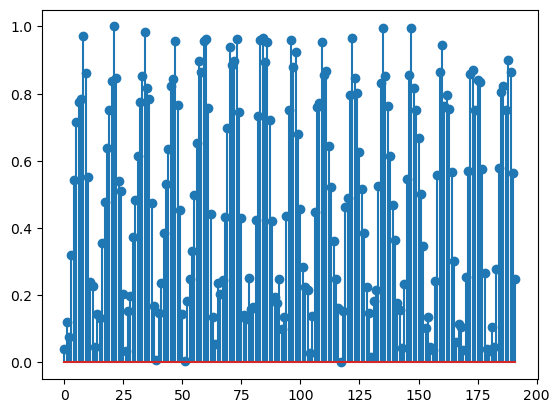

In [12]:
plt.stem(Y_lstm_test[10,:])

In [13]:
print(X_lstm_train.shape, Y_lstm_train.shape)
print(X_lstm_test.shape, Y_lstm_test.shape)

(2838, 4, 192) (2838, 192)
(150, 4, 192) (150, 192)


In [14]:
latent_dim = 192

def lstm_split(input_shape, nseg, v_shape):
    def Slice(s):
        # function for slicing x
        def func(x):
            return x[:, s, :]

        return func

    # define shared layers
    dense = Dense(v_shape, activation="relu")
    inputs = Input(shape=input_shape)
    con_list = []
    for s in range(nseg):
        # slicing x
        x = Lambda(Slice(s))(inputs)
        # shared layers
        x = dense(x)
        con_list.append(x)

    # concat and reshape for LSTM
    x = Concatenate(axis=1)(con_list)
    x = Reshape((nseg, int(x.shape[1] / nseg)))(x)

    x = LSTM(v_shape)(x)
    x = Activation("softmax")(x)

    return Model(inputs, x)

In [15]:
model = lstm_split(
    input_shape=(nseg, latent_dim), nseg=nseg, v_shape=Y0_30_35_40.shape[1]
)
model.compile(optimizer="adam", loss="MeanSquaredError")
print(model.summary())

2023-10-23 14:12:53.171937: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46672 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2023-10-23 14:12:53.173830: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46672 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4, 192)]     0           []                               
                                                                                                  
 lambda (Lambda)                (None, 192)          0           ['input_1[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 192)          0           ['input_1[0][0]']                
                                                                                                  
 lambda_2 (Lambda)              (None, 192)          0           ['input_1[0][0]']                
                                                                                              

2023-10-23 14:12:53.768832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-23 14:12:53.770117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-23 14:12:53.770977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [ ]:
epochs = 100
batch_size = 16

history = model.fit(
    X_lstm_train,
    Y_lstm_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_lstm_test, Y_lstm_test),
)

Epoch 1/100


2023-10-23 14:12:54.248378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-23 14:12:54.249902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-23 14:12:54.250942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  1/178 [..............................] - ETA: 9:16 - loss: 0.3426

2023-10-23 14:12:57.033197: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


178/178 [==============================] - 4s 8ms/step - loss: 0.3413 - val_loss: 0.3413
Epoch 2/100
  1/178 [..............................] - ETA: 1s - loss: 0.3392

2023-10-23 14:12:58.371930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-23 14:12:58.373496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-23 14:12:58.374603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

178/178 [==============================] - 1s 5ms/step - loss: 0.3411 - val_loss: 0.3413
Epoch 3/100
178/178 [==============================] - 1s 6ms/step - loss: 0.3411 - val_loss: 0.3412
Epoch 4/100
178/178 [==============================] - 1s 5ms/step - loss: 0.3411 - val_loss: 0.3412
Epoch 5/100
178/178 [==============================] - 1s 5ms/step - loss: 0.3411 - val_loss: 0.3412
Epoch 6/100
178/178 [==============================] - 1s 5ms/step - loss: 0.3411 - val_loss: 0.3412
Epoch 7/100
178/178 [==============================] - 1s 5ms/step - loss: 0.3411 - val_loss: 0.3412
Epoch 8/100
178/178 [==============================] - 1s 5ms/step - loss: 0.3411 - val_loss: 0.3412
Epoch 9/100
178/178 [==============================] - 1s 5ms/step - loss: 0.3411 - val_loss: 0.3412
Epoch 10/100
178/178 [==============================] - 1s 5ms/step - loss: 0.3411 - val_loss: 0.3412
Epoch 11/100
178/178 [==============================] - 1s 5ms/step - loss: 0.3411 - val_loss: 0.3412


In [ ]:
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
preds = model.predict(X_lstm_test)

In [ ]:
plt.stem(preds[10,:])

In [ ]:
plt.stem(Y_lstm_test[15,:])